Лабораторная работа 2. Ассоциативные правила

Цель работы: исследование методов анализа ассоциативных правил.

Вариант датасета: 2 (Market Basket Optimisation) <br> <br>
Описание датасета: набор данных, используемый в данном датасете, содержит товары, купленные клиентами вместе.
Каждая строка соответствует одной транзакции.
Нужно определить, какие товары чаще всего покупают вместе, чтобы размещать их рядом и использовать в акциях.

1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx
from collections import Counter
import numpy as np
from mlxtend.frequent_patterns import fpgrowth

all_data = pd.read_csv('Market_Basket_Optimisation.csv')
print(f"Размер: {all_data.shape}")

Размер: (7500, 20)


2. Анализ транзакций

Количество транзакций: 7500
Общее количество записей (товаров): 29343


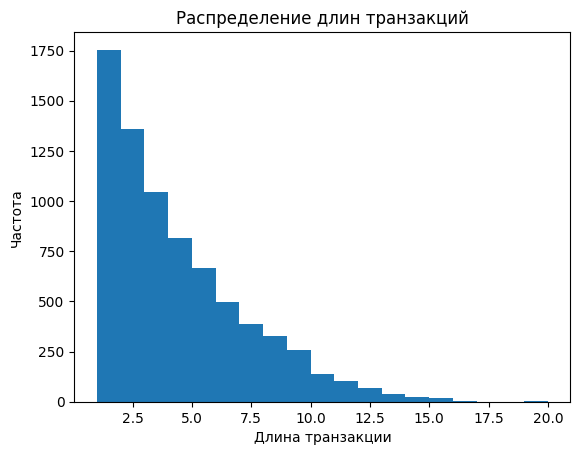

Минимальная длина транзакции: 1
Максимальная длина транзакции: 19
Средняя длина транзакции: 3.91
Медиана длины транзакции: 3.0


In [2]:
print(f"Количество транзакций: {len(all_data)}")
print(f"Общее количество записей (товаров): {all_data.count().sum()}")

transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

print(f"Минимальная длина транзакции: {transaction_lengths.min()}")
print(f"Максимальная длина транзакции: {transaction_lengths.max()}")
print(f"Средняя длина транзакции: {transaction_lengths.mean():.2f}")
print(f"Медиана длины транзакции: {transaction_lengths.median()}")

По гистограмме видно, что чаще всего встречаются транзакции с небольшим числом товаров (от 1 до 3). 

Медиана равна 3.0, что означает, что половина всех транзакций содержит 3 или меньше товаров. Среднее значение (3.91) немного выше медианы, это указывает на наличие редких длинных транзакций (до 19 товаров), смещающих среднее вправо. 

3. Очищение данных и создание списка уникальных товаров

In [3]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row if isinstance(elem, str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)
print(f'Количество уникальных товаров: {len(unique_items)}')

{'cream', 'mushroom cream sauce', 'candy bars', 'antioxydant juice', 'burger sauce', 'oil', 'honey', 'spaghetti', 'cake', 'salmon', 'white wine', 'escalope', 'cauliflower', 'rice', 'champagne', 'hot dogs', 'bacon', 'soda', 'cookies', 'meatballs', 'chili', 'mayonnaise', 'hand protein bar', 'oatmeal', 'flax seed', 'milk', 'spinach', 'nonfat milk', 'yams', 'salad', 'butter', 'carrots', 'vegetables mix', 'grated cheese', 'fromage blanc', 'tomato sauce', 'babies food', 'gluten free bar', 'melons', 'pet food', 'frozen smoothie', 'parmesan cheese', 'whole wheat pasta', 'chocolate', 'sparkling water', 'shrimp', 'mineral water', 'eggplant', 'pepper', 'protein bar', 'muffins', 'frozen vegetables', 'bug spray', 'herb & pepper', 'light mayo', 'french wine', 'whole wheat rice', 'corn', 'energy drink', ' asparagus', 'almonds', 'ham', 'gums', 'avocado', 'water spray', 'strawberries', 'fresh tuna', 'yogurt cake', 'mint green tea', 'chicken', 'cider', 'pancakes', 'tomato juice', 'black tea', 'soup', 't

4. Построение диаграммы: Топ-10 самых частых товаров

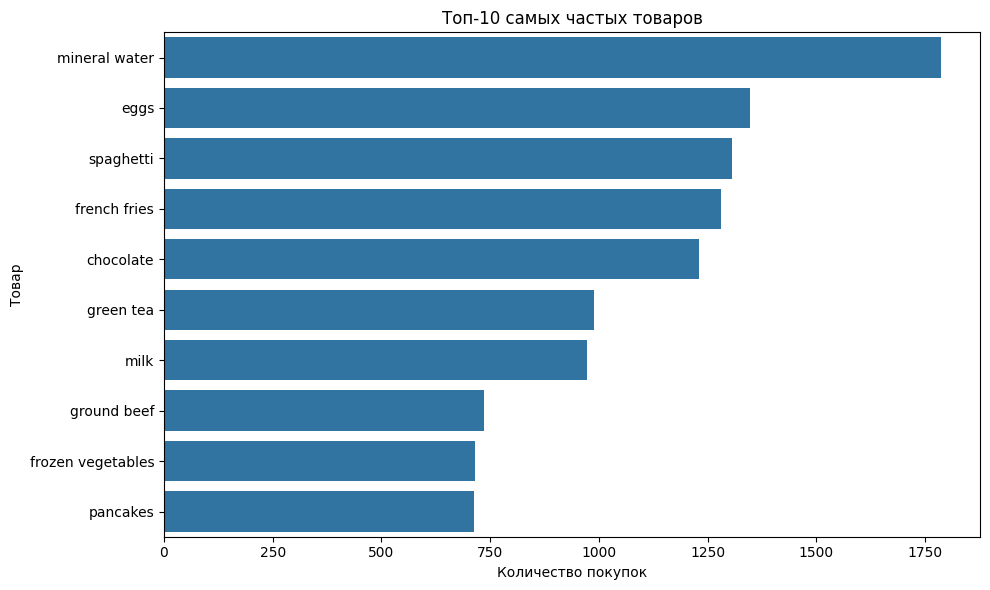

In [4]:
all_items = [item for row in np_data for item in row]
item_counts = Counter(all_items)
top_items = item_counts.most_common(10)
items, counts = zip(*top_items)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(items))
plt.title('Топ-10 самых частых товаров')
plt.xlabel('Количество покупок')
plt.ylabel('Товар')
plt.tight_layout()
plt.show()

По диаграмме видно, что самый часто покупаемый товар это mineral water, его купили примерно 1750 раз, в то время как топ-10 замыкает товар pancakes, его купили меньше 750 раз.

5. Применение алгоритма Apriori. Этот алгоритм помогает находить группы товаров, часто покупаемых вместе.

Алгоритм работает в несколько шагов: 
1) определение частых наборов товаров <br>
2) создание возможных групп товаров <br>
3) удаление нечастых групп товаров <br>

Начальные параметры: поддержка(support) = 0.02 и достоверность(confidence) = 0.25 <br>
Поддержка — это число транзакций, входящих в набор, разделённое на общее количество транзакций. <br>
Формула:<br>
![alt text](image.png) <br>
Формула вычисляет частоту встречаемости набора X среди всех транзакций. <br>

Достоверность — это условная вероятность определённого товара оказаться в корзине с другими товарами. <br>
Формула:<br>
![alt text](image-1.png),<br>
![alt text](image-2.png),<br>
![alt text](image-3.png) <br>

In [5]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

df1 = apriori(data, min_support=0.02, use_colnames = True)
df1 = df1.sort_values(by='support', ascending=False)
print("Частые наборы")
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(f"Количество найденных правил: {len(rules)}")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Частые наборы
     support                           itemsets
34  0.238267                    (mineral water)
13  0.179733                             (eggs)
44  0.174133                        (spaghetti)
17  0.170933                     (french fries)
9   0.163867                        (chocolate)
..       ...                                ...
67  0.020133       (cooking oil, mineral water)
81  0.020133   (frozen smoothie, mineral water)
79  0.020133           (french fries, pancakes)
99  0.020133  (mineral water, whole wheat rice)
71  0.020000                (ground beef, eggs)

[104 rows x 2 columns]
Количество найденных правил: 28
            antecedents      consequents   support  confidence      lift
0       (mineral water)      (spaghetti)  0.059733    0.250699  1.439698
1           (spaghetti)  (mineral water)  0.059733    0.343032  1.439698
2           (chocolate)  (mineral water)  0.052667    0.321400  1.348907
3                (eggs)  (mineral water)  0.050933    0.283383

По данным частых наборов видно, что самый популярный товар это mineral water с support = 0.238, то есть 23.8% всех транзакций содержат данный товар. Реже всего всречалось товарное сочетание eggs и ground beef (support = 0.02). <br>
В результате применения алгоритма получилось 28 ассоциативных правил.

6. Анализ полученных правил и определение количества полезных и тривиальных правил. <br>

Lift - мера значимости ассоциативных правил. Это отношение частоты появления условия в транзакциях, которые также содержат и следствие, к частоте появления следствия в целом. <br>

Формула: <br>
![alt text](image-4.png)<br>
Интерпретация значений : <br>
Lift > 1 - сильная ассоциация между товарами <br>
Lift = 1 - ассоциация отсутствует <br>
Lift < 1 - наличие одного снижает вероятность появления другого <br>
 
Коэффициент лифта варьируется от 0 до бесконечности, и чем больше этот коэффициент, тем сильнее связь. <br>

Полезные правила содержат достоверную информацию, ранее неизвестную, но имеющую логическое объяснение. Такие правила могут быть использованы для принятия решений, приносящих выгоду.<br>
Тривиальные правила содержат достоверную и легко объяснимую информацию, которая уже известна. Такие правила, хотя и объяснимы, но не могут принести пользы, так как отражают известные законы в исследуемой области или результаты прошлой деятельности.

In [6]:
rules_lift = rules.sort_values(by='lift', ascending=False)
print("Правила с высоким lift (топ-10):")
print(rules_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

rules_conf = rules.sort_values(by='confidence', ascending=False)
print("\nПравила с высокой confidence (топ-10):")
print(rules_conf[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


print("\nТривиальные правила:")
print("(burgers) => (french fries)")
print("(shrimp) => (spaghetti)")

print("Остальные правила являются полезными.")

Правила с высоким lift (топ-10):
            antecedents      consequents   support  confidence      lift
6         (ground beef)      (spaghetti)  0.039200    0.398915  2.290857
20          (olive oil)      (spaghetti)  0.022933    0.348884  2.003547
19               (soup)  (mineral water)  0.023067    0.456464  1.915771
10            (burgers)           (eggs)  0.028800    0.330275  1.837585
24           (tomatoes)      (spaghetti)  0.020933    0.306043  1.757520
13          (olive oil)  (mineral water)  0.027467    0.417850  1.753707
5         (ground beef)  (mineral water)  0.040933    0.416554  1.748266
23             (shrimp)      (spaghetti)  0.021200    0.297196  1.706717
11  (frozen vegetables)      (spaghetti)  0.027867    0.292308  1.678643
25        (cooking oil)  (mineral water)  0.020133    0.394256  1.654683

Правила с высокой confidence (топ-10):
            antecedents      consequents   support  confidence      lift
19               (soup)  (mineral water)  0.023067 

In [7]:
print(f"Средняя достоверность: {rules['confidence'].mean():.3f}")
print(f"Средний lift: {rules['lift'].mean():.3f}")
print(f"Максимальный lift: {rules['lift'].max():.3f}")
print(f"Минимальный lift: {rules['lift'].min():.3f}")

Средняя достоверность: 0.336
Средний lift: 1.575
Максимальный lift: 2.291
Минимальный lift: 1.174


Правило с самым высоким lift это ground beef - spaghetti (lift = 2.290857).
Правило с самой высокой confidence это soup - mineral water (confidence = 0.456464).Все правила имеют lift > 1 => связь сильно выражена. Некоторые правила имеют confidence > 0.4 => высокая вероятность совместной покупки.
Из 28 правил 2 правила тривиальны, остальные 26 полезны и значимы.

7. Проведение оценки влияния параметров алгоритма на получаемые правила (на количество правил и метрики). <br>
Значения support: 0.01, 0.02, 0.03 <br>
Значения confidence: 0.2, 0.25, 0.3 <br>

   support  confidence  num_rules  avg_confidence  avg_lift
0     0.01        0.20        162        0.288600  1.640224
1     0.01        0.25         95        0.335050  1.742316
2     0.01        0.30         63        0.368149  1.774111
3     0.02        0.20         56        0.278235  1.467930
4     0.02        0.25         28        0.335985  1.575443
5     0.02        0.30         20        0.360657  1.617689
6     0.03        0.20         27        0.262197  1.424236
7     0.03        0.25         10        0.338768  1.564517
8     0.03        0.30          7        0.368562  1.634935


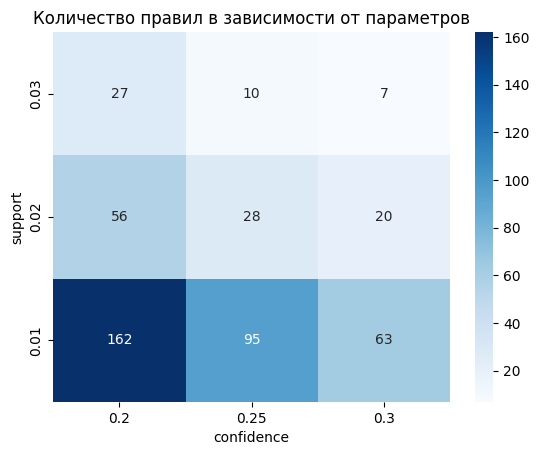

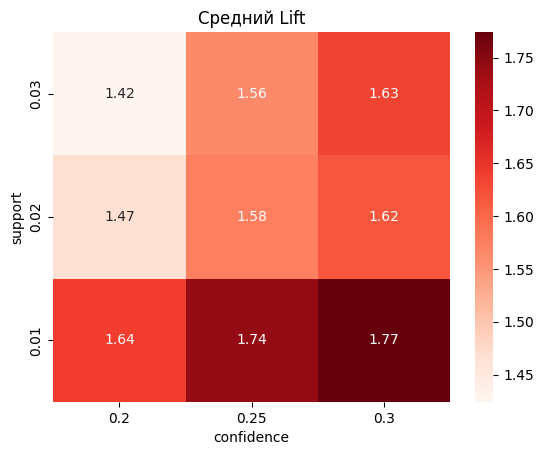

In [8]:
results = []
supports = [0.01, 0.02, 0.03]
confidences = [0.2, 0.25, 0.3]

for sup in supports:
    for conf in confidences:
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        rule_set = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rule_set)
        avg_confidence = rule_set['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rule_set['lift'].mean() if num_rules > 0 else 0
        useful_rules = len(rule_set[rule_set['lift'] > 1])

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_confidence,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)


import seaborn as sns
import matplotlib.pyplot as plt

pivot_table = results_df.pivot(index='support', columns='confidence', 
                               values='num_rules').sort_index(ascending=False)
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap="Blues")
plt.title('Количество правил в зависимости от параметров')
plt.show()

pivot_lift = results_df.pivot(index='support', columns='confidence', 
                              values='avg_lift').sort_index(ascending=False)
sns.heatmap(pivot_lift, annot=True, fmt='.2f', cmap="Reds")
plt.title('Средний Lift')
plt.show()

Больше всего правил (162) при значениях параметров support = 0.01 и confidence = 0.2 <br>
Меньше всего правил (7) при значениях параметров support = 0.03 и confidence = 0.3  <br>
Среднее значение lift больше всего (1.77) при значениях параметров support = 0.01 и confidence = 0.3<br>
Меньше всего среднее значение lift (1.42) при значениях параметров support = 0.03 и confidence = 0.2  <br>

8. Проведение анализа ассоциативных правил с использованием алгоритма FPG. <br>

Начальные параметры: поддержка(support) = 0.02 и достоверность(confidence) = 0.25 <br>

Алгоритм Frequent Pattern-Growth (FPG) — алгоритм для поиска ассоциативных правил. Цель алгоритма — найти в наборе данных все часто встречающиеся наборы элементов с поддержкой, которая превышает минимально заданную. <br>

Особенности:<br>
1) Использует компактную древовидную структуру — FP-дерево (Frequent Pattern Tree), которая хранит информацию о часто встречающихся шаблонах без многократного сканирования исходного набора данных; <br>
2) Позволяет избежать затратной процедуры генерации кандидатов, характерной для алгоритма Apriori.<br>

Алгоритм FPG выполняется в два этапа: <br>
1. Построение FP-дерева. <br>
2. Извлечение из FP-дерева частых предметных наборов.<br>

In [9]:
df2 = fpgrowth(data, min_support=0.02, use_colnames=True)
print("Частые наборы (FPG):")
print(df2)

rules = association_rules(df2, metric="confidence", min_threshold=0.25)

print(f"\nКоличество правил: {len(rules)}")
print(f"Средняя достоверность: {rules['confidence'].mean():.3f}")
print(f"Средний lift: {rules['lift'].mean():.3f}")


Частые наборы (FPG):
      support                          itemsets
0    0.179733                            (eggs)
1    0.087200                         (burgers)
2    0.020933                       (meatballs)
3    0.062533                          (turkey)
4    0.033200                         (avocado)
..        ...                               ...
99   0.020000               (ground beef, eggs)
100  0.020133  (frozen smoothie, mineral water)
101  0.027467             (mineral water, cake)
102  0.027467        (mineral water, olive oil)
103  0.022933            (olive oil, spaghetti)

[104 rows x 2 columns]

Количество правил: 28
Средняя достоверность: 0.336
Средний lift: 1.575


In [10]:
print("\nПравила (FPG):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print("\nТривиальные правила:")
print("(burgers) => (french fries)")
print("(shrimp) => (spaghetti)")

print("Остальные правила являются полезными.")


Правила (FPG):
            antecedents      consequents   support  confidence      lift
0                (eggs)  (mineral water)  0.050933    0.283383  1.189351
1             (burgers)           (eggs)  0.028800    0.330275  1.837585
2             (burgers)  (mineral water)  0.024400    0.279817  1.174384
3             (burgers)   (french fries)  0.022000    0.252294  1.475976
4                (milk)  (mineral water)  0.048000    0.370370  1.554436
5                (milk)      (spaghetti)  0.035467    0.273663  1.571569
6    (whole wheat rice)  (mineral water)  0.020133    0.343964  1.443608
7      (low fat yogurt)  (mineral water)  0.023867    0.312391  1.311098
8                (soup)  (mineral water)  0.023067    0.456464  1.915771
9       (mineral water)      (spaghetti)  0.059733    0.250699  1.439698
10          (spaghetti)  (mineral water)  0.059733    0.343032  1.439698
11  (frozen vegetables)      (spaghetti)  0.027867    0.292308  1.678643
12  (frozen vegetables)  (mineral w

Частые наборы: <br>
(eggs) — самый популярный товар: 17.97% транзакций содержат яйца (support = 0.179733).<br>

В результате применения алгоритма FPG было получено также 28 ассоциативных правил. Из них всё те же 2 правила являются тривиальными, а остальные - полезными.<br>

9. Определение алгоритмически минимальных значений поддержки для составления правил из 1, 2, и т.д. объектов в алгоритме FPG.

In [11]:
def find_min_support_for_item_count(data, max_items=5, min_supp_start=0.005, 
                                    step=0.001):
    results = {n: None for n in range(1, max_items + 1)}
    current_support = min_supp_start
    
    while current_support >= 0.001 and any(v is None for v in results.values()):
        try:
            frequent_itemsets = fpgrowth(data, min_support=current_support, use_colnames=True)
            frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
            
            for n in range(1, max_items + 1):
                if results[n] is None:  
                    subset = frequent_itemsets[frequent_itemsets['length'] == n]
                    if not subset.empty:
                        results[n] = current_support
                        
            current_support -= step
            
        except Exception as e:
            print(f"Ошибка при support={current_support}: {e}")
            break
    
    return results

min_supports = find_min_support_for_item_count(data)
print("\nРезультаты:")
for n, supp in min_supports.items():
    if supp is not None:
        print(f"Минимальный support для itemset с {n} товарами: {supp:.4f}")
    else:
        print(f"Нет itemset с {n} товарами")


Результаты:
Минимальный support для itemset с 1 товарами: 0.0050
Минимальный support для itemset с 2 товарами: 0.0050
Минимальный support для itemset с 3 товарами: 0.0050
Минимальный support для itemset с 4 товарами: 0.0040
Минимальный support для itemset с 5 товарами: 0.0020


Минимальные значения поддержки для получения ассоциативных правил с разным количеством товаров: для 1–3 товаров: найдены при min_support = 0.005; для 4 и 5 товаров правила найдены при min_support 0.004 и 0.002 соответственно, поддержка меньше, т.к. такие наборы довольно редки.

10. Получение набора ассоциативных правил путём последовательной замены параметров (значения поддержки и достоверности) алгоритма FPG.

In [12]:
supports = [0.01, 0.02, 0.03]
confidences = [0.2, 0.25, 0.3]
results = []

for sup in supports:
    for conf in confidences:
        frequent_itemsets = fpgrowth(data, min_support=sup, use_colnames=True)
        temp_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)

        num_rules = len(temp_rules)
        avg_conf = temp_rules['confidence'].mean() if num_rules > 0 else 0
        avg_lift = temp_rules['lift'].mean() if num_rules > 0 else 0

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_conf,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)

   support  confidence  num_rules  avg_confidence  avg_lift
0     0.01        0.20        162        0.288600  1.640224
1     0.01        0.25         95        0.335050  1.742316
2     0.01        0.30         63        0.368149  1.774111
3     0.02        0.20         56        0.278235  1.467930
4     0.02        0.25         28        0.335985  1.575443
5     0.02        0.30         20        0.360657  1.617689
6     0.03        0.20         27        0.262197  1.424236
7     0.03        0.25         10        0.338768  1.564517
8     0.03        0.30          7        0.368562  1.634935


Последовательно изменяя параметры min_support и min_confidence, получены следующие наборы ассоциативных правил: 

При min_support = 0.01, min_confidence = 0.2 — 162 правила, средний lift = 1.64. <br>
При min_support = 0.03, min_confidence = 0.3 — 7 правил, средний lift = 1.63. <br>
Повышение параметров приводит к уменьшению количества правил, но увеличению их качества.

11. Построение диаграммы Топ-10 товаров по поддержке

     support           itemsets
5   0.238267      mineral water
0   0.179733               eggs
14  0.174133          spaghetti
11  0.170933       french fries
20  0.163867          chocolate
6   0.132000          green tea
7   0.129600               milk
33  0.098267        ground beef
15  0.095333  frozen vegetables
29  0.095067           pancakes


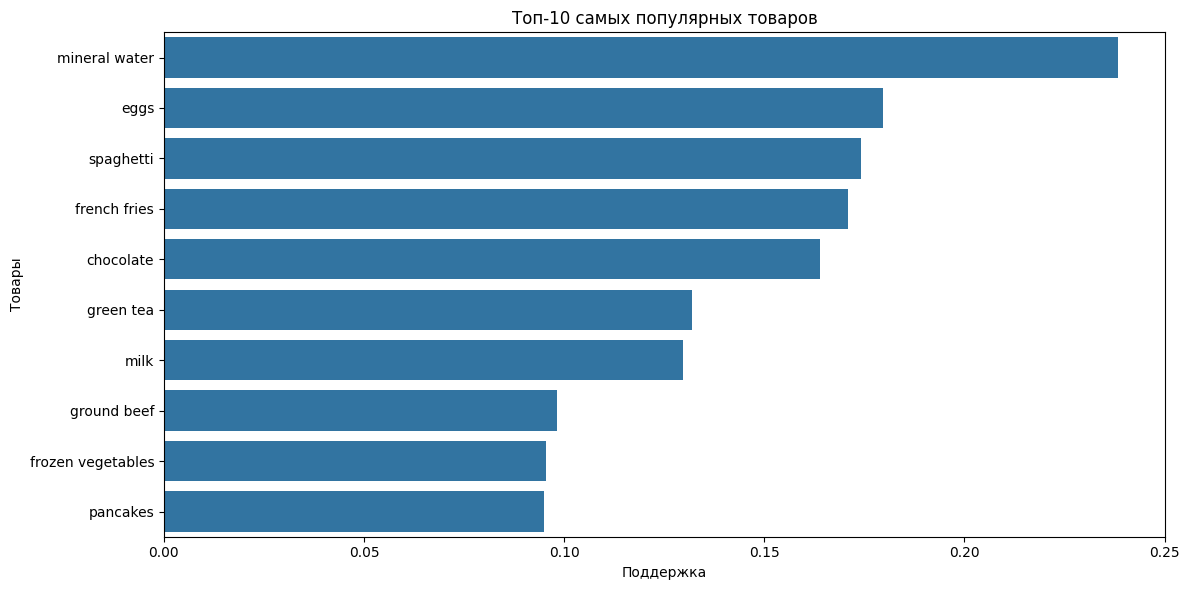

In [13]:
df2['itemsets'] = df2['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df2.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных товаров')
plt.xlabel('Поддержка')
plt.ylabel('Товары')
plt.tight_layout()
plt.show()

У товара mineral water самое большое значение support (0.238267), а у товара pancakes - самое маленькое (в топ-10), support = 0.095067 <br>

12. Построение графика достоверности, который показывает, насколько сильно связаны товары в правилах.

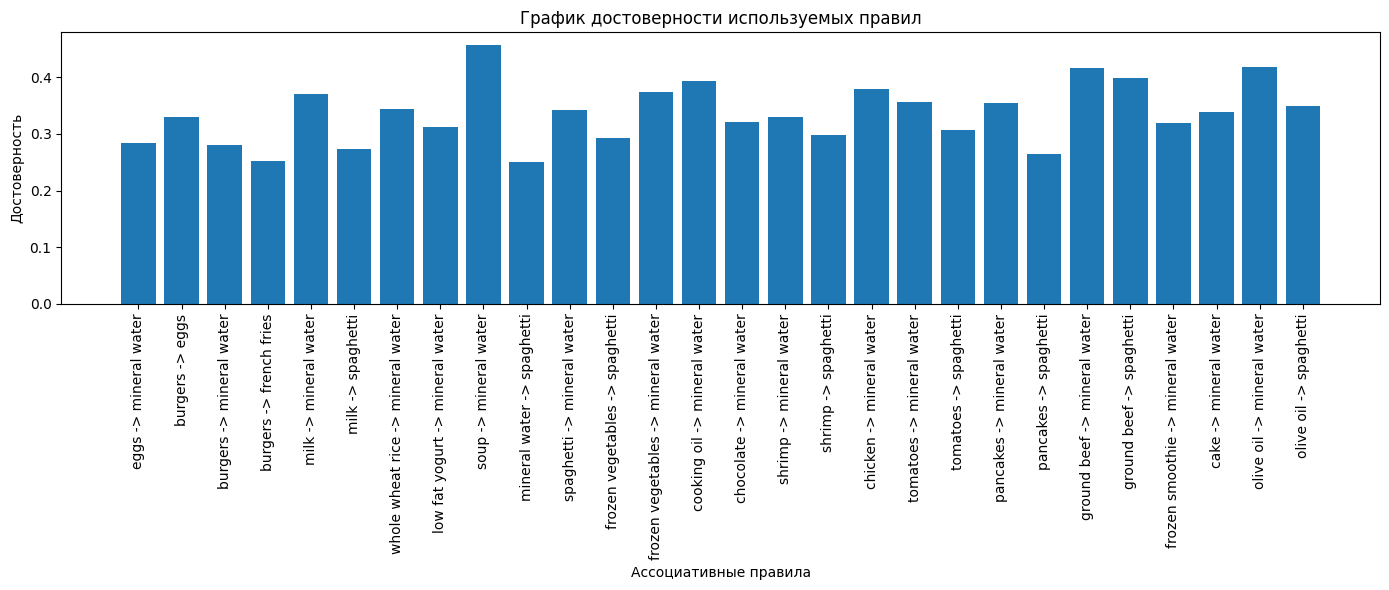

In [14]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]

plt.figure(figsize=(14, 6))
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

На графике отображены значения достоверности для каждого из 28 правил. <br>
soup - mineral water (confidence = 0.456464) - это самое сильное правило, значит есть очень высокая вероятность совместной покупки.
Самая слабая достоверность у правил: burgers - french fires, mineral water - spaghetti, pancakes - spaghetti.

13. Визуализация ассоциативных правил в виде графа, где узлы (вершины) — это товары, рёбра (связи) — это ассоциативные правила, а вес ребра — это достоверность (confidence) правила.

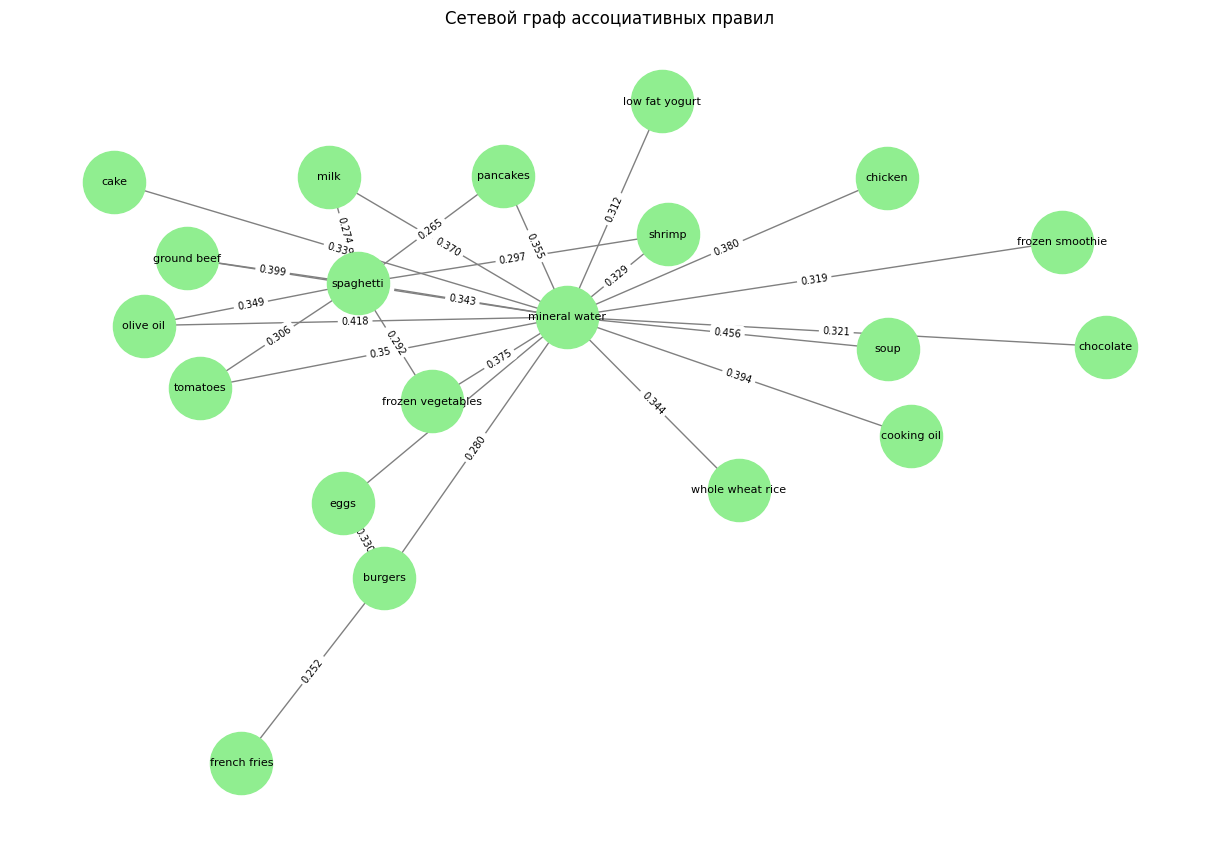

In [15]:
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightgreen', 
        font_size=8, edge_color='gray')
edge_labels = {k: f"{v:.3f}" for k, v in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title('Сетевой граф ассоциативных правил')
plt.show()

На сетевом графе явно выделяется центральный узел: mineral water. <br>
Очень многие товары связаны с этим узлом.
Это означает, что большинство правил имеют mineral water в правой или левой части (по графику достоверности правил видно, что довольно часто mineral water находится в правой части).  

14. Визуализация ассоциативных правил с помощью bubble chart <br>
X = support, Y = confidence, размер точки = lift

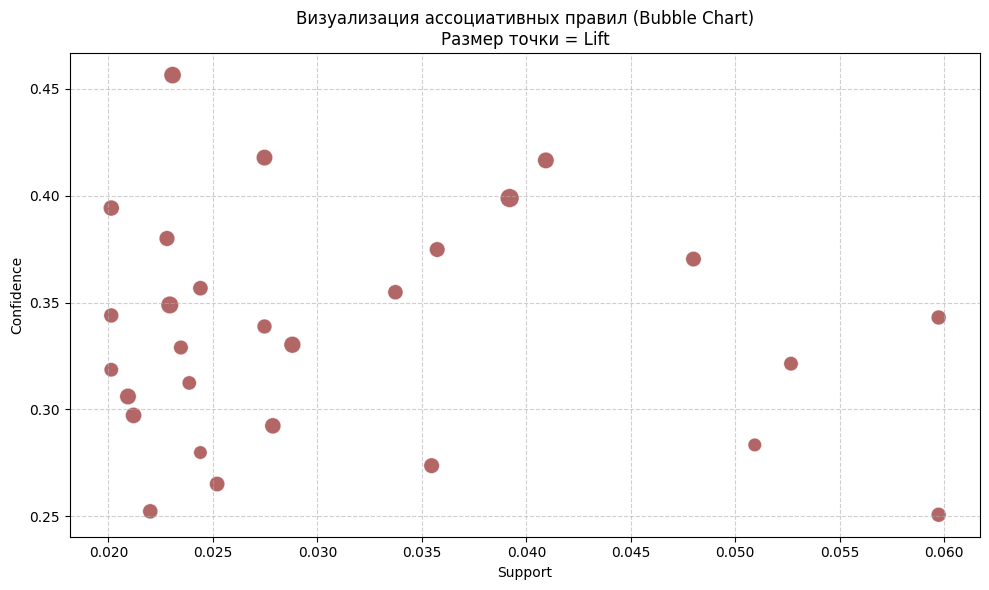

Самая большая точка (max lift):
  Support: 0.039
  Confidence: 0.399
  Lift: 2.291
  Rule: ground beef - spaghetti

Самая маленькая точка (min lift):
  Support: 0.024
  Confidence: 0.280
  Lift: 1.174
  Rule: burgers - mineral water


In [16]:
x = rules['support']
y = rules['confidence']
sizes = rules['lift'] * 80 

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, s=sizes, c='maroon', alpha=0.6, 
                      edgecolors="w", linewidth=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Визуализация ассоциативных правил (Bubble Chart)\nРазмер точки = Lift')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

max_lift_idx = rules['lift'].idxmax()
min_lift_idx = rules['lift'].idxmin()

print("Самая большая точка (max lift):")
print(f"  Support: {rules.loc[max_lift_idx, 'support']:.3f}")
print(f"  Confidence: {rules.loc[max_lift_idx, 'confidence']:.3f}")
print(f"  Lift: {rules.loc[max_lift_idx, 'lift']:.3f}")
print(f"  Rule: {rules.loc[max_lift_idx, 'antecedents']} - {rules.loc[max_lift_idx, 'consequents']}")

print("\nСамая маленькая точка (min lift):")
print(f"  Support: {rules.loc[min_lift_idx, 'support']:.3f}")
print(f"  Confidence: {rules.loc[min_lift_idx, 'confidence']:.3f}")
print(f"  Lift: {rules.loc[min_lift_idx, 'lift']:.3f}")
print(f"  Rule: {rules.loc[min_lift_idx, 'antecedents']} - {rules.loc[min_lift_idx, 'consequents']}")

На графике представлены все 28 ассоциативных правил в виде пузырьков различного размера. По графику видно, что нет правил с очень высокой поддержкой (>0.06) и высокой достоверностью (>0.4) одновременно.

Самый большой пузырёк  это самое сильное и значимое правило правило: ground beef - spaghetti.

Самый маленький пузырёк это самое слабое правило: burgers - mineral water.

15. Заключение <br>

В ходе лабораторной работы был проанализирован датасет Market Basket Optimisation, содержащий информацию о купленных вместе товарах.

С помощью алгоритма Apriori с параметрами: поддержка 0.02 и достоверность 0.25 было найдено 28 ассоциативных правил, из них 2 являются тривиальными, а остальные - полезными.

Наиболее сильные правила: (ground beef - spaghetti), (soup - mineral water).

При помощи алгоритма FPG также было найдено 28 ассоциативных правил, что подтверждает корректность работы алгоритмов.

FPG показал более высокую производительность при аналогичных параметрах.
Наиболее значимые правила: (burgers - eggs), (olive oil - spaghetti).

Также были определены минимальные значения min_support, при которых появляются правила с 1, 2 и 3 товарами. Например, для правила из 3 товаров минимальный support = 0.0101.

Проанализировав влияние параметров, можно заметить, что при увеличении min_support и min_confidence количество правил уменьшается, а средний lift и confidence увеличиваются, что указывает на более сильные, но менее многочисленные правила.

Сетевой граф показал, что mineral water является центральным узлом, к которому привязано большинство  товаров.
Это указывает на высокую популярность минеральной воды как дополнительного товара при покупке других товаров.

Для дополнительной визуализации ассоциативных правил был реализован Bubble Chart, в котором: <br>
ось X — support <br>
ось Y — confidence <br>
размер точки — lift. <br>
Визуализация позволила наглядно сравнить силу правил и выделить наиболее значимое (ground beef - spaghetti).